In [177]:
import pint
si = pint.UnitRegistry()

In [178]:
from matplotlib import pyplot
si.setup_matplotlib()

In [179]:
%run mpdata.ipynb

In [180]:
%run coord.ipynb

In [181]:
def plot_done():
    pyplot.grid()
    pyplot.legend()
    
def plot_step(r, pdf, t):
    pyplot.step(r, pdf, linestyle='-', where='mid', label=str(t))

In [182]:
nr = 32
nt = 100
dt = .4 * si.second
r_min = 5 * si.micrometre
r_max = 101 * si.micrometre
r_mid = r_min + .4*(r_max - r_min) 
pdf0 = lambda r: 1 / ((r-r_mid)**2 + 1 * r_mid.units**2)
drdt = lambda r: .5 * si.micrometre / si.second

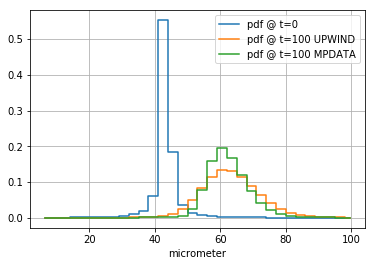

In [183]:
algos = (
    MPDATA(nr, r_min, r_max, dt, pdf0, x_id(si), {"n_it":1}),
    MPDATA(nr, r_min, r_max, dt, pdf0, x_id(si), {"n_it":2, "dfl":False})
)

plot_step(algos[0].r, algos[0].pdf, "pdf @ t=0")

for algo in algos:
    for t in range(nt): 
        algo.step(drdt)

plot_step(algos[0].r, algos[0].pdf, "pdf @ t=" + str(nt) + " UPWIND")
plot_step(algos[1].r, algos[1].pdf, "pdf @ t=" + str(nt) + " MPDATA")
plot_done()

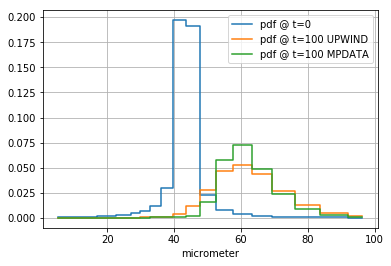

In [184]:
algos = (
    MPDATA(nr, r_min, r_max, dt, pdf0, x_ln(si), {"n_it":1}),
    MPDATA(nr, r_min, r_max, dt, pdf0, x_ln(si), {"n_it":2, "dfl":False})
)

plot_step(algos[0].r, algos[0].pdf, "pdf @ t=0")

for algo in algos:
    for t in range(nt):   
        algo.step(drdt)

plot_step(algos[0].r, algos[0].pdf, "pdf @ t=" + str(nt) + " UPWIND")
plot_step(algos[1].r, algos[1].pdf, "pdf @ t=" + str(nt) + " MPDATA")
plot_done()